# IBEX 35 portfolio recommendation

## Introduction

The IBEX 35 is the benchmark stock market index of the [Bolsa de Madrid](http://www.bolsamadrid.es/ing/aspx/Portada/Portada.aspx), designed to represent the
performance of the largest securities traded on the Spanish Stock Market. 

IBEX 35 is made up by the 35 most liquid securities traded on the Spanish Stock Market. Selection criteria of constituents have
no sector diversification bias. IBEX 35 constituents are weighted by market capitalisation adjusted by free float.

[Bolsas y Mercados](https://www.bolsasymercados.es/ing/Home) (BME).  calculates, publishes and disseminates in real-time the
IBEX Index. BME, the company that integrates the principal securities markets and financial systems in Spain, is Europe's fifth biggest exchange operator by equity turnover according to data from FESE. 

Since 1992, IBEX 35 has been the underlying index for futures and options contracts traded on BME’s Derivatives Market ([MEFF](http://www.meff.es/ing/Home)). IBEX 35 is also the benchmark for Exchange-traded funds (ETFs) issued by BBVA Asset Management and Lyxor Asset Management.
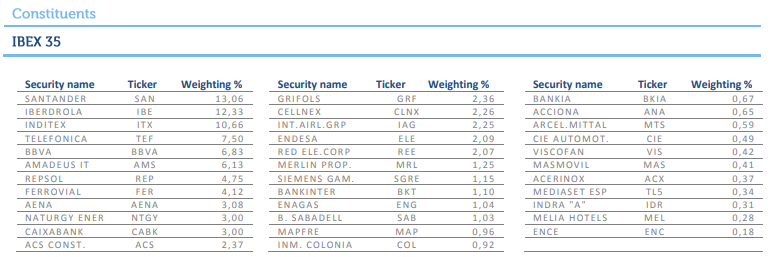
<cite data-cite="http://www.bolsamadrid.es">(http://www.bolsamadrid.es)</cite>

## Business Problem

One of our clients at our wealth manager is looking to invest EUR 100,000 of their savings in a portfolio stock. Our company is specialised in the European markets and this client is looking to diversify their portfolio.

The client is very happy with our service and currently have investments in United Kingdom, France and Germany. As a start point, we have suggested that would be a good opportunity to explore a market with more potential return and the Spanish market it is working very well for other clients.

After receiving some information, the client is happy to explore this market. After completing an assessment on our client´s profile, we will approach our study following the below conditions:
- The client is looking to maximize the portfolio returns
- The portfolio should be composed by at least 5 different stocks
- The client does not want to be exposed too much to one sector

## Data description

In order to start our study, we will going to use [pandas_datareader](https://pandas-datareader.readthedocs.io/en/latest/) and [Yahoo finance](https://finance.yahoo.com/) API to get our data. Then, we will get the adjusted closing price of the stock since 2015. We will use quarterly data.

In order to simplify our study we are going to use the 10 biggest companies of the Ibex 35: Aena, Amadeus, BBVA, Endesa, Iberdrola, Inditex, Repsol, Santander, Siemens-Gamesa and Telefónica.

We are going to use the adjusted closing price for our study, as this price includes any corporate action affecting each particular company.

## Methodology

We are going to use a Markowitz mean-variance optimization (MVO), an approach to choosing how to allocate money between multiple assets by considering the risk-return trade-off of asset combinations.

The approach considers the expected returns and covariance for all assets. It returns a set of portfolios where:
- The expected return is greater than any other with the same or lesser risk
- The risk is less than any other with the same expected return

We will use the mean of the daily returns as our expected return and then we will calculate the efficient frontier - the set of portfolios optimized for risk and return.

### 1. Load and Explore the Stocks

In [1]:
#import libraries
import pandas as pd
import numpy as np
import pandas_datareader as web
import matplotlib.pyplot as plt

In [2]:
top_10_ibex_35 = [
    "AENA.MC", "AMS.MC", "BBVA.MC", "ELE.MC", "IBE.MC",
    "ITX.MC", "REP.MC", "SAN.MC", "SGRE.MC", "TEF.MC"
          ]
start_date = "2015-02-11"
end_date = "2019-09-30"
stock_data = web.get_data_yahoo(top_10_ibex_35, start_date, end_date)

Lets have a look of the data we are retrieving from Yahoo Finance

In [3]:
stock_data.head()

Attributes  Adj Close                                                       \
Symbols       AENA.MC     AMS.MC   BBVA.MC     ELE.MC    IBE.MC     ITX.MC   
Date                                                                         
2015-02-11  58.879158  31.653589  6.098383  12.688087  4.747787  23.650713   
2015-02-12  58.879158  32.171757  6.255433  12.785861  4.793811  24.080727   
2015-02-13  62.243683  32.289936  6.448901  12.785861  4.804494  24.378078   
2015-02-16  60.981991  32.249016  6.404138  12.417328  4.743678  24.153917   
2015-02-17  63.000702  32.249016  6.488353  12.451172  4.779017  24.163069   

Attributes                                              ...          Volume  \
Symbols        REP.MC    SAN.MC   SGRE.MC    TEF.MC     ...         AENA.MC   
Date                                                    ...                   
2015-02-11  12.215891  4.692762  9.259046  9.183902     ...      16216420.0   
2015-02-12  12.500957  4.815968  9.562172  9.272492     ...      55651797.0   
2015-02-13  12.869637  4.936038  9.490790  9.339795     ...       8380785.0   
2015-02-16  12.824028  4.928969  9.548482  9.314997     ...        827945.0   
2015-02-17  12.816425  4.949379  9.533816  9.307901     ...       2630220.0   

Attributes                                                            \
Symbols         AMS.MC     BBVA.MC     ELE.MC      IBE.MC     ITX.MC   
Date                                                                   
2015-02-11   1707151.0  30287509.0  2895251.0  51690669.0  3731573.0   
2015-02-12  13048283.0  52952890.0  3629137.0  35337338.0  4508171.0   
2015-02-13   1538500.0  57200390.0  4408647.0  23945584.0  3427564.0   
2015-02-16   7022700.0  74838264.0  3860813.0  27843777.0  1868279.0   
2015-02-17   1476640.0  36555946.0  3338315.0  20698466.0  2766428.0   

Attributes                                                 
Symbols         REP.MC      SAN.MC    SGRE.MC      TEF.MC  
Date                                                       
2015-02-11  10248221.0  90316241.0  3377295.0  31999205.0  
2015-02-12   6850641.0  65443698.0  5147005.0  16000430.0  
2015-02-13   8971413.0  88230439.0  3236361.0  19247585.0  
2015-02-16   4205367.0  37953843.0  1659152.0  10723739.0  
2015-02-17   8388551.0  49706895.0  1943835.0  18823267.0  

[5 rows x 60 columns]

For our study we are using the adjusted closing price, so lets create a smaller dataset:

In [4]:
stock_data_adj_close = stock_data['Adj Close']
stock_data_adj_close.head()

Symbols,AENA.MC,AMS.MC,BBVA.MC,ELE.MC,IBE.MC,ITX.MC,REP.MC,SAN.MC,SGRE.MC,TEF.MC
Date,,,,,,,,,,
2015-02-11,58.879158,31.653589,6.098383,12.688087,4.747787,23.650713,12.215891,4.692762,9.259046,9.183902
2015-02-12,58.879158,32.171757,6.255433,12.785861,4.793811,24.080727,12.500957,4.815968,9.562172,9.272492
2015-02-13,62.243683,32.289936,6.448901,12.785861,4.804494,24.378078,12.869637,4.936038,9.490790,9.339795
2015-02-16,60.981991,32.249016,6.404138,12.417328,4.743678,24.153917,12.824028,4.928969,9.548482,9.314997
2015-02-17,63.000702,32.249016,6.488353,12.451172,4.779017,24.163069,12.816425,4.949379,9.533816,9.307901


We will convert the data to quarterly so we get a best representation:

In [5]:
stock_data_adj_close = stock_data_adj_close.resample('Q').last()
stock_data_adj_close.head()

Symbols,AENA.MC,AMS.MC,BBVA.MC,ELE.MC,IBE.MC,ITX.MC,REP.MC,SAN.MC,SGRE.MC,TEF.MC
Date,,,,,,,,,,
2015-03-31,78.654144,36.326180,7.342734,13.537970,4.932702,27.337843,13.177504,5.506541,11.504138,9.504148
2015-06-30,78.847603,32.503567,6.861959,12.909961,4.965575,26.918602,12.330650,5.023462,13.816698,9.410282
2015-09-30,83.061676,35.084518,5.967538,14.490535,4.911424,27.634151,8.149971,3.835518,12.173198,7.993205
2015-12-31,88.655197,37.342411,5.362572,14.248257,5.409420,29.381517,8.283171,3.721877,15.555735,7.770338
2016-03-31,95.426300,34.909603,4.769752,13.261686,4.938130,27.411314,8.119471,3.204755,17.074924,7.479566


### 2. Simple Rate of Return (RoR)

The rate of return is a measure of the amount of money gained or lost in an investment. A positive return signifies a profit and a negative return indicates a loss.

So, here we have the closing price of the 10 companies we are going to study in order to prepare the portfolio allocation. Now, we need to calculate the daily simple rate of return (RoR) of each stock. 
This is easily calculated using the [pct_change()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pct_change.html) method in pandas!

In [6]:
simple_rate_of_return = stock_data_adj_close.pct_change()

Lets have a look at the first rows:

In [7]:
simple_rate_of_return.head()

Symbols,AENA.MC,AMS.MC,BBVA.MC,ELE.MC,IBE.MC,ITX.MC,REP.MC,SAN.MC,SGRE.MC,TEF.MC
Date,,,,,,,,,,
2015-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-30,0.002460,-0.105230,-0.065476,-0.046389,0.006664,-0.015336,-0.064265,-0.087728,0.201020,-0.009876
2015-09-30,0.053446,0.079405,-0.130345,0.122431,-0.010905,0.026582,-0.339048,-0.236479,-0.118950,-0.150588
2015-12-31,0.067342,0.064356,-0.101376,-0.016720,0.101396,0.063232,0.016344,-0.029628,0.277868,-0.027882
2016-03-31,0.076376,-0.065149,-0.110548,-0.069241,-0.087124,-0.067056,-0.019763,-0.138941,0.097661,-0.037421


### 3. Stock Performance - Expected RoR

We can easily plot our data to compare the performance of each stock during this period. We will use the same index (in this case 100) to see the evolution of each stock.

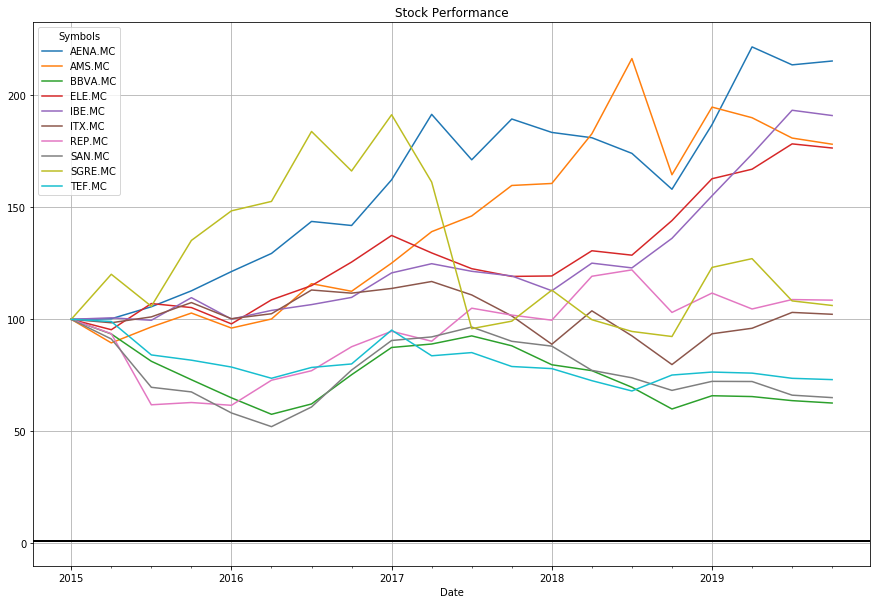

In [8]:
performance = stock_data_adj_close.apply(lambda x: (x / x[0])*100)
performance.plot(grid = True, figsize=(15,10), title = "Stock Performance").axhline(y = 1, color = "black", lw = 2)

In [9]:
performance.tail(1)

Symbols,AENA.MC,AMS.MC,BBVA.MC,ELE.MC,IBE.MC,ITX.MC,REP.MC,SAN.MC,SGRE.MC,TEF.MC
Date,,,,,,,,,,
2019-12-31,215.309705,178.163523,62.632438,176.466635,190.970384,102.248547,108.556224,65.047392,106.179187,73.083883


We can see that there are 4 stocks below the 100 (so return is negative) and the rest are above 100 (so they have positive returns). The stock with the biggest return is AENA (+ 115%) and the worst return is BBVA (- 38%).

#### Expected RoR

After visualising how good or bad the stocks have been performing during the year, we need need the expected return of each stock, this will help us on our portfolio selection. We can assume that the expected return is the mean of the RoR:

In [10]:
expected_ror = simple_rate_of_return.mean()
expected_ror

Symbols
AENA.MC    0.044903
AMS.MC     0.036578
BBVA.MC   -0.019720
ELE.MC     0.032577
IBE.MC     0.036701
ITX.MC     0.004853
REP.MC     0.012572
SAN.MC    -0.015629
SGRE.MC    0.019087
TEF.MC    -0.013592
dtype: float64

As expected, the best Aena gets the best expected rate of return (+4.49%) and BBVA the worst (-2.1%). Lets plot this information.

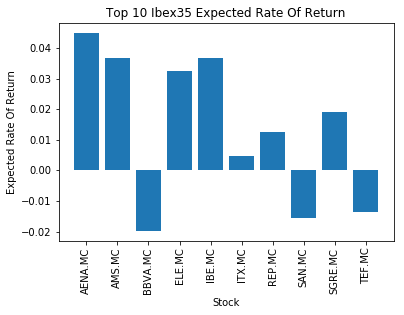

In [11]:
symbols = expected_ror.index
plt.bar(x = symbols,height = expected_ror)
plt.xticks(rotation='vertical')
plt.xlabel('Stock')
plt.ylabel('Expected Rate Of Return')
plt.title('Top 10 Ibex35 Expected Rate Of Return')
plt.show()

### 3. Analysing the Risk

The risk of an investment is defined as the likelihood of suffering a financial loss.

We can try to understand the risk using the variance, how far apart each value is from the mean. An asset with a high variance is generally a riskier one because its return can vary significantly in a short period of time, making it less stable and more unpredictable.

In [12]:
variance = simple_rate_of_return.var()
variance

Symbols
AENA.MC    0.008197
AMS.MC     0.011730
BBVA.MC    0.009988
ELE.MC     0.004860
IBE.MC     0.004502
ITX.MC     0.007856
REP.MC     0.015841
SAN.MC     0.014563
SGRE.MC    0.031722
TEF.MC     0.005954
dtype: float64

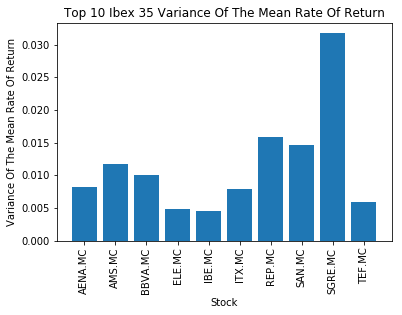

In [13]:
plt.bar(x = symbols ,height = variance)
plt.xticks(rotation='vertical')
plt.xlabel('Stock')
plt.ylabel('Variance Of The Mean Rate Of Return')
plt.title('Top 10 Ibex 35 Variance Of The Mean Rate Of Return')
plt.show()

Siemens-Gamesa shows the highest variance of all the stocks, indicating it can be a riskier investment. Endesa and Iberdrola show the lowest variance, indicating that the returns are more predictable. This goes along with the typical understanding of higher return, high risks stocks, and lower return, low risk stocks.

In order to compare better the risk of each stock, it is better to use the Standard Deviation as this statistic uses the same unit.

In [14]:
stdev = simple_rate_of_return.std()
stdev * 100

Symbols
AENA.MC     9.053962
AMS.MC     10.830489
BBVA.MC     9.994234
ELE.MC      6.971171
IBE.MC      6.709766
ITX.MC      8.863427
REP.MC     12.586282
SAN.MC     12.067655
SGRE.MC    17.810562
TEF.MC      7.716465
dtype: float64

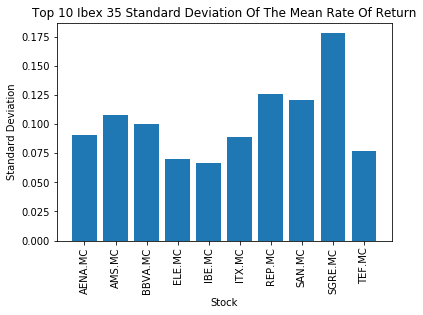

In [15]:
plt.bar(x = symbols ,height = stdev)
plt.xticks(rotation='vertical')
plt.xlabel('Stock')
plt.ylabel('Standard Deviation')
plt.title('Top 10 Ibex 35 Standard Deviation Of The Mean Rate Of Return')
plt.show()

We can see like 2 groups in terms of volatility:
1. Volatility above 10% (High volatility): Amadeus,Repsol, Santander and Siemens-Gamesa. Siemens-Gamesa has the highest volatility, 17.81%
2. Volatility below 10% (Medium-Low volatility: Aena, BBVA, Endesa, Iberdrola, Inditex and Telefonica. It is good to mention that Endesa and Iberdrola have both the lowest volatility, 6.97% & 6.70% respectively

We also can see some companies from the same sector and similar values. For example, big banks as Santander and BBVA and electric companies like Iberdrola and Endesa seem to have similar volatility. This will help us in order to choose our portfolio.

#### Correlation

Here we are going to analyse if how the stocks are correlated each other. In order to create our portfolio, we do not want to get exposure to securities that are correlated each other, as this will generate more risk. As per our analysis on the Standard Deviation, we have already seen some similar behaviour in some stocks.

In [17]:
correlation = simple_rate_of_return.corr()
correlation

Symbols,AENA.MC,AMS.MC,BBVA.MC,ELE.MC,IBE.MC,ITX.MC,REP.MC,SAN.MC,SGRE.MC,TEF.MC
Symbols,,,,,,,,,,
AENA.MC,1.000000,0.436544,0.294261,0.045748,0.269492,0.454739,-0.081132,0.184172,0.493260,-0.042702
AMS.MC,0.436544,1.000000,0.312001,0.050984,0.039933,0.488881,0.322039,0.205585,0.099635,-0.222153
BBVA.MC,0.294261,0.312001,1.000000,0.206551,0.273552,0.376231,0.483238,0.892574,0.009648,0.497443
ELE.MC,0.045748,0.050984,0.206551,1.000000,0.595840,0.413324,0.027305,0.095037,0.111233,0.259364
IBE.MC,0.269492,0.039933,0.273552,0.595840,1.000000,0.606518,0.178103,0.185562,0.205763,0.328047
ITX.MC,0.454739,0.488881,0.376231,0.413324,0.606518,1.000000,0.330295,0.124785,0.218271,-0.066859
REP.MC,-0.081132,0.322039,0.483238,0.027305,0.178103,0.330295,1.000000,0.480268,-0.055721,0.258501
SAN.MC,0.184172,0.205585,0.892574,0.095037,0.185562,0.124785,0.480268,1.000000,0.126251,0.624053
SGRE.MC,0.493260,0.099635,0.009648,0.111233,0.205763,0.218271,-0.055721,0.126251,1.000000,0.302206


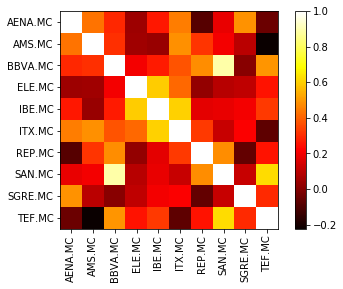

In [19]:
plt.imshow(correlation, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(rotation='vertical')
plt.xticks(range(len(correlation)), correlation.columns)
plt.yticks(range(len(correlation)), correlation.columns);

As expected, Santander and BBVA have really high correlation of 0.898. Also we have high correlation between Endesa and Iberdrola: 0.578 (maybe a bit lower than I would expect).
On the other hand, Telefónica and Amadeus have the strongest negative correlation.

#### Covariance

In order to help balance our our portfolio, we can see the relationship between the returns of the different stocks we are analysing. So, we can create our covariance matrix and see what conclusion we can get.

In [20]:
#lets calcuate all stocks covariance
covariance = simple_rate_of_return.cov()
covariance

Symbols,AENA.MC,AMS.MC,BBVA.MC,ELE.MC,IBE.MC,ITX.MC,REP.MC,SAN.MC,SGRE.MC,TEF.MC
Symbols,,,,,,,,,,
AENA.MC,0.008197,0.004281,0.002663,0.000289,0.001637,0.003649,-0.000925,0.002012,0.007954,-0.000298
AMS.MC,0.004281,0.011730,0.003377,0.000385,0.000290,0.004693,0.004390,0.002687,0.001922,-0.001857
BBVA.MC,0.002663,0.003377,0.009988,0.001439,0.001834,0.003333,0.006079,0.010765,0.000172,0.003836
ELE.MC,0.000289,0.000385,0.001439,0.004860,0.002787,0.002554,0.000240,0.000800,0.001381,0.001395
IBE.MC,0.001637,0.000290,0.001834,0.002787,0.004502,0.003607,0.001504,0.001503,0.002459,0.001698
ITX.MC,0.003649,0.004693,0.003333,0.002554,0.003607,0.007856,0.003685,0.001335,0.003446,-0.000457
REP.MC,-0.000925,0.004390,0.006079,0.000240,0.001504,0.003685,0.015841,0.007295,-0.001249,0.002511
SAN.MC,0.002012,0.002687,0.010765,0.000800,0.001503,0.001335,0.007295,0.014563,0.002714,0.005811
SGRE.MC,0.007954,0.001922,0.000172,0.001381,0.002459,0.003446,-0.001249,0.002714,0.031722,0.004153


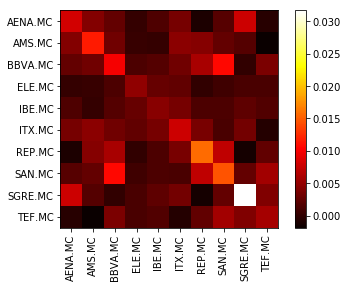

In [21]:
plt.imshow(covariance, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(rotation='vertical')
plt.xticks(range(len(covariance)), covariance.columns)
plt.yticks(range(len(covariance)), covariance.columns);

It is important to include in our portfolio  stocks that don't move in the same direction. We can see example like Aena vs Repsol or Telefonica vs Amadeus.

### 3. Sharpe Ratio

The Sharpe ratio was developed by Nobel laureate William F. Sharpe and is used to help investors understand the return of an investment compared to its risk. The ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk.

Subtracting the risk-free rate from the mean return allows an investor to better isolate the profits associated with risk-taking activities. Generally, the greater the value of the Sharpe ratio, the more attractive the risk-adjusted return.
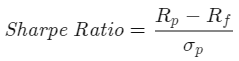

- Rp = return of portfolio
- Rf = risk-free rate
- σp = standard deviation of the portfolio’s excess return

The risk-free rate of return is the theoretical rate of return of an investment with zero risk. The risk-free rate represents the interest an investor would expect from an absolutely risk-free investment over a specified period of time. The real risk-free rate can be calculated by subtracting the current inflation rate from the yield of the Treasury bond matching your investment duration.

For simplicity, we will consider Rf = 0

So, for instance lets do an hypothetical portfolio allocation and we will then calculate the Sharpe ratio.

In [22]:
#portfolio weight
portfolio_weight =np.asarray([0.1, 0.1, 0.1, 0.1, 0.1,
                    0.1, 0.1, 0.1, 0.1, 0.1])

#lets calculate the expected quarterly return
portfolio_return = np.sum(expected_ror * portfolio_weight)

#now we need the standard deviation
portfolio_std = np.sqrt(np.dot(portfolio_weight.T, np.dot(covariance, portfolio_weight)))

#Sharpe ratio, Rf = 0
sharpe_ratio = (portfolio_return - 0) / portfolio_std
sharpe_ratio

0.23627542773566326

[What is a good Sharpe ratio?](https://www.investopedia.com/ask/answers/010815/what-good-sharpe-ratio.asp)
- Any Sharpe ratio greater than 1.0 is considered acceptable to good by investors.
- A ratio higher than 2.0 is rated as very good.
- A ratio of 3.0 or higher is considered excellent.
- A ratio under 1.0 is considered sub-optimal.

Although this is the theory, Sharpe ratio it is a controversial way of saying how good it is your portfolio, but could be good to compare investments. Have a look to this [link](http://www.win-vector.com/blog/2015/06/what-is-a-good-sharpe-ratio/). 

So, I am going to use the sharpe ratio more to compare my different allocations.

### 4. Selecting our portfolio

Our analysis on the risk and return of the stock selected, gave us a good overview of how can we play later in selecting more accurately our portfolio. For instance, we know that SAN and BBVA / ENE and IBE behave very similar each other, so we will be able to discard some stocks, in order to get a better portfolio.

So, now it is time to do our mean-variance portfolio optimization to get the efficient frontier of best portfolios. For doing that, we will simulate imaginary combinations of portfolios (100,000 portfolios in this case). And then we will get the efficient frontier.

Lets create some functions as we are going to repeat the same process with our different selection.

In [18]:
#this will calculate return, std and sharpe ratio of each portfolio
def calc_portfolio_perf(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio

#this will generate random portfolios
def simulate_random_portfolios(num_portfolios, mean_returns, cov, rf, tickers):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio = calc_portfolio_perf(weights, mean_returns, cov, rf)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = sharpe_ratio
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','sharpe'] + [ticker for ticker in tickers])
        
    return results_df

In [19]:
#display value in percent form
def display_as_percentage(val):
    return '{:.1f}%'.format(val * 100)

#print results
def print_results(type_string, max_min_str, select_type):
    print("If we {0} the {1} we get a return of {2}, \
volatility of {3} and sharpe ratio of {4}"
      .format(max_min_str,
              type_string,
             display_as_percentage(select_type[0]),
             display_as_percentage(select_type[1]),
             display_as_percentage(select_type[2])))

#lets define the portfolio selection function
def portfolio_selection(stocks):
    mean_returns = expected_ror[stocks]
    cov = simple_rate_of_return[stocks].cov()
    num_portfolios = 100000
    rf = 0.0
    results_df = simulate_random_portfolios(num_portfolios, mean_returns, cov, rf, stocks)
    return results_df

### Efficient frontier 

#### All stocks

We are going to start using all the 10 stocks and then we will narrow our selection.

In [20]:
all_stocks = [
    "AENA.MC", "AMS.MC", "BBVA.MC", "ELE.MC", "IBE.MC",
    "ITX.MC", "REP.MC", "SAN.MC", "SGRE.MC", "TEF.MC"
          ]
results_frame = portfolio_selection(all_stocks)

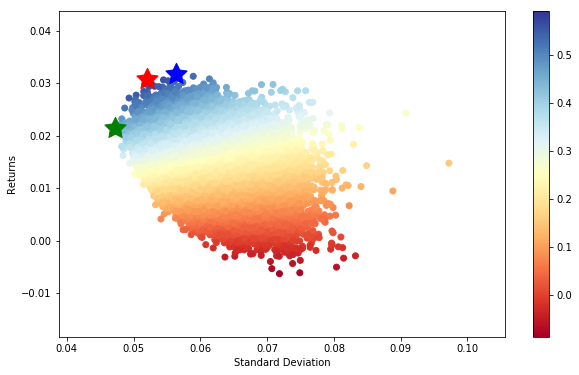

In [21]:
#locate portfolio with highest Sharpe Ratio
max_sharpe_portfolio = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate portfolio with minimum standard deviation
min_volatility_portfolio = results_frame.iloc[results_frame['stdev'].idxmin()]
#locate portfolio with maximum return
max_return_portfolio = results_frame.iloc[results_frame['ret'].idxmax()]

#create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize=(10,6))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_portfolio[1],max_sharpe_portfolio[0],marker=(5,1,0),color='r',s=500)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_volatility_portfolio[1],min_volatility_portfolio[0],marker=(5,1,0),color='g',s=500)
#plot blue star to highlight position of maximum return portfolio
plt.scatter(max_return_portfolio[1],max_return_portfolio[0],marker=(5,1,0),color='b',s=500)
plt.show()

So, the more optimal portfolios are those where the scatter plot is more blue. That is the efficient frontier. The red star is the portfolio with the best sharpe ratio, the blue start is one with the best return and the green one the portfolio with less risk.

In [22]:
print_results("Sharpe Ratio", "maximise", max_sharpe_portfolio)
print_results("Return", "maximise", max_return_portfolio)
print_results("Volatility", "minimise", min_volatility_portfolio)

If we maximise the Sharpe Ratio we get a return of 3.1%, volatility of 5.2% and sharpe ratio of 59.2%
If we maximise the Return we get a return of 3.2%, volatility of 5.6% and sharpe ratio of 56.3%
If we minimise the Volatility we get a return of 2.2%, volatility of 4.7% and sharpe ratio of 45.6%


So, if we select for example the best Sharpe Ratio, our allocation would be:

In [23]:
max_sharpe_portfolio.to_frame().T

,ret,stdev,sharpe,AENA.MC,AMS.MC,BBVA.MC,ELE.MC,IBE.MC,ITX.MC,REP.MC,SAN.MC,SGRE.MC,TEF.MC
35051,0.030748,0.051974,0.591607,0.246924,0.122648,0.021356,0.198632,0.261739,0.025984,0.000346,0.019024,0.033361,0.069988


#### First selection

For our first selection, we already know from our previous analysis that some stocks have a big correlation. This is the case of BBVA and Santander (both big banks) and Endesa and Iberdrola (both electric utility companies). We are going to select 1 of each and then we are going to see if our sharpe ratio has improved.

Lets check return vs standard deviation:
- BBVA: -1.9% vs 9.99%
- SAN: -1.5% vs 12.06%
- ELE: 3.2% vs 7.41%
- IBE: 3.6% vs 6.70%

BBVA and Santander both have expected negative return. I am going to keep Santader and then remove it, so we can see that maybe is a good idea to not include stocks with expected negative return.
Between Endesa and Iberdrola I am going to select Iberdrola as it seems that the returns are better with less volatility.

In [24]:
first_selection_stocks = [
    "AENA.MC", "AMS.MC", "IBE.MC",
    "ITX.MC", "REP.MC", "SAN.MC", "SGRE.MC", "TEF.MC"
          ]
results_frame = portfolio_selection(first_selection_stocks)

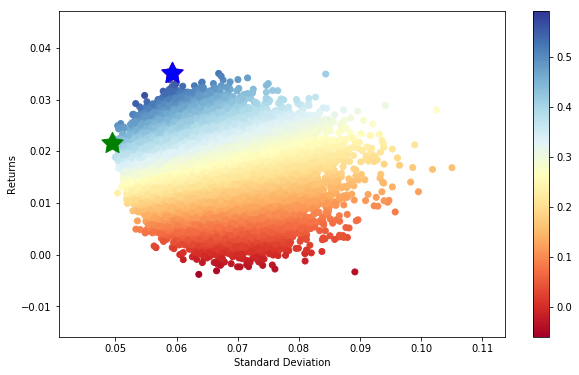

In [25]:
#locate portfolio withhighest Sharpe Ratio
max_sharpe_portfolio = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate portfolio with minimum standard deviation
min_volatility_portfolio = results_frame.iloc[results_frame['stdev'].idxmin()]
#locate portfolio with maximum return
max_return_portfolio = results_frame.iloc[results_frame['ret'].idxmax()]

#create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize=(10,6))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_portfolio[1],max_sharpe_portfolio[0],marker=(5,1,0),color='r',s=500)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_volatility_portfolio[1],min_volatility_portfolio[0],marker=(5,1,0),color='g',s=500)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(max_return_portfolio[1],max_return_portfolio[0],marker=(5,1,0),color='b',s=500)
plt.show()

In [26]:
print_results("Sharpe Ratio", "maximise", max_sharpe_portfolio)
print_results("Return", "maximise", max_return_portfolio)
print_results("Volatility", "minimise", min_volatility_portfolio)

If we maximise the Sharpe Ratio we get a return of 3.5%, volatility of 5.9% and sharpe ratio of 59.2%
If we maximise the Return we get a return of 3.5%, volatility of 5.9% and sharpe ratio of 59.2%
If we minimise the Volatility we get a return of 2.2%, volatility of 4.9% and sharpe ratio of 43.6%


So, with this selection we have the same results if we maximise Returns or Sharpe ratio. We have improved the return with a similar Sharpe ratio. On the other hand, our portfolio more conservative is performing worse.

#### Second selection

What happens if we remove all the stocks with a negative expected return?

Let´s come back to the first step and lets just remove those stocks with negative returns:
- BBVA -2.1%
- Santander -1.5%
- Telefonica -1.3%

In [27]:
#remove negative return stocks
no_negative_return = [
    "AENA.MC", "AMS.MC", "ELE.MC", "IBE.MC",
    "ITX.MC", "REP.MC", "SGRE.MC"
          ]
results_frame = portfolio_selection(no_negative_return)

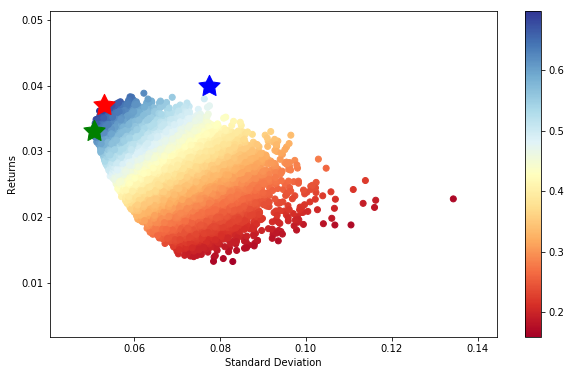

In [28]:
#locate portfolio withhighest Sharpe Ratio
max_sharpe_portfolio = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate portfolio with minimum standard deviation
min_volatility_portfolio = results_frame.iloc[results_frame['stdev'].idxmin()]
#locate portfolio with maximum return
max_return_portfolio = results_frame.iloc[results_frame['ret'].idxmax()]

#create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize=(10,6))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_portfolio[1],max_sharpe_portfolio[0],marker=(5,1,0),color='r',s=500)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_volatility_portfolio[1],min_volatility_portfolio[0],marker=(5,1,0),color='g',s=500)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(max_return_portfolio[1],max_return_portfolio[0],marker=(5,1,0),color='b',s=500)
plt.show()

In [29]:
print_results("Sharpe Ratio", "maximise", max_sharpe_portfolio)
print_results("Return", "maximise", max_return_portfolio)
print_results("Volatility", "minimise", min_volatility_portfolio)

If we maximise the Sharpe Ratio we get a return of 3.7%, volatility of 5.3% and sharpe ratio of 69.8%
If we maximise the Return we get a return of 4.0%, volatility of 7.7% and sharpe ratio of 51.6%
If we minimise the Volatility we get a return of 3.3%, volatility of 5.1% and sharpe ratio of 65.5%


Our returns have improved on all our approaches. Best Sharpe ratio approach seems to work really well. This is telling us that an aggressive investment does not really provide us any benefit.

We are going to do another further analysis and discard Endesa again and see the values.

In [30]:
#remove negative return stocks and intercorrelated
no_negative_return_no_inter = [
    "AENA.MC", "AMS.MC", "IBE.MC",
    "ITX.MC", "REP.MC", "SGRE.MC"
          ]
results_frame = portfolio_selection(no_negative_return_no_inter)

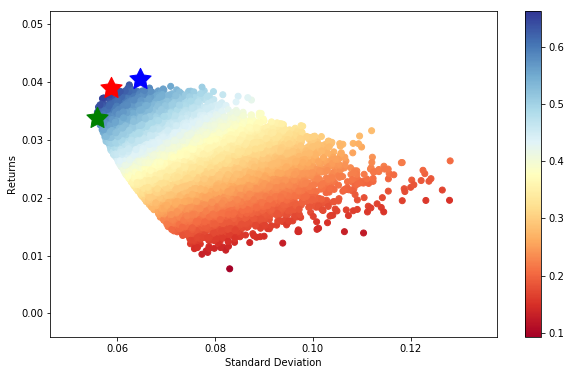

In [31]:
#locate portfolio withhighest Sharpe Ratio
max_sharpe_portfolio = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate portfolio with minimum standard deviation
min_volatility_portfolio = results_frame.iloc[results_frame['stdev'].idxmin()]
#locate portfolio with maximum return
max_return_portfolio = results_frame.iloc[results_frame['ret'].idxmax()]

#create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize=(10,6))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_portfolio[1],max_sharpe_portfolio[0],marker=(5,1,0),color='r',s=500)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_volatility_portfolio[1],min_volatility_portfolio[0],marker=(5,1,0),color='g',s=500)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(max_return_portfolio[1],max_return_portfolio[0],marker=(5,1,0),color='b',s=500)
plt.show()

In [32]:
print_results("Sharpe Ratio", "maximise", max_sharpe_portfolio)
print_results("Return", "maximise", max_return_portfolio)
print_results("Volatility", "minimise", min_volatility_portfolio)

If we maximise the Sharpe Ratio we get a return of 3.9%, volatility of 5.9% and sharpe ratio of 66.3%
If we maximise the Return we get a return of 4.1%, volatility of 6.5% and sharpe ratio of 62.8%
If we minimise the Volatility we get a return of 3.4%, volatility of 5.6% and sharpe ratio of 60.4%


It seems we are doing a good job improving our expected returns but this is increasing the volatility of our portfolio, therefore our Sharpe ratio is worse than on our previous scenario.

#### Third selection

So, looking again risk vs return, we can see that Siemens-Gamesa has the highest volatility but returns are a bit better than Repsol only. Also, Repsol have some negative correlation with Siemens-Gamesa and also with Aena. It seems to be a sensible choice not to include Siemens-Gamesa.

In [33]:
#removing Siemens-Gamesa
third_selection = [
    "AENA.MC", "AMS.MC", "IBE.MC",
    "ITX.MC", "REP.MC"
          ]
results_frame = portfolio_selection(third_selection)

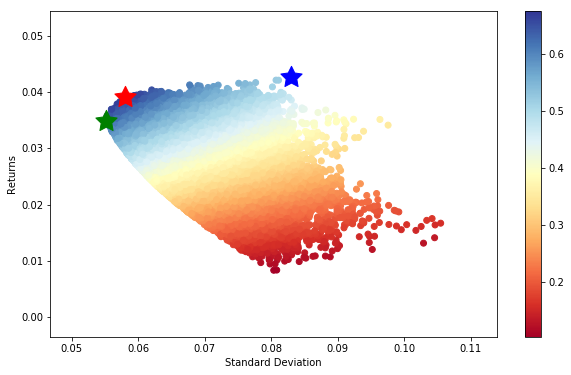

In [34]:
#locate portfolio withhighest Sharpe Ratio
max_sharpe_portfolio = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate portfolio with minimum standard deviation
min_volatility_portfolio = results_frame.iloc[results_frame['stdev'].idxmin()]
#locate portfolio with maximum return
max_return_portfolio = results_frame.iloc[results_frame['ret'].idxmax()]

#create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize=(10,6))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_portfolio[1],max_sharpe_portfolio[0],marker=(5,1,0),color='r',s=500)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_volatility_portfolio[1],min_volatility_portfolio[0],marker=(5,1,0),color='g',s=500)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(max_return_portfolio[1],max_return_portfolio[0],marker=(5,1,0),color='b',s=500)
plt.show()

In [35]:
print_results("Sharpe Ratio", "maximise", max_sharpe_portfolio)
print_results("Return", "maximise", max_return_portfolio)
print_results("Volatility", "minimise", min_volatility_portfolio)

If we maximise the Sharpe Ratio we get a return of 3.9%, volatility of 5.8% and sharpe ratio of 67.6%
If we maximise the Return we get a return of 4.3%, volatility of 8.3% and sharpe ratio of 51.4%
If we minimise the Volatility we get a return of 3.5%, volatility of 5.5% and sharpe ratio of 63.3%


So, our expected returns are going in the good direction and it seems that the Sharpe ratio is similar to the best one so far.

So we can see below the weights of the portfolios that seems to be good choices for our client:

1. Best Return

In [36]:
max_return_portfolio.to_frame().T

,ret,stdev,sharpe,AENA.MC,AMS.MC,IBE.MC,ITX.MC,REP.MC
39763,0.042666,0.082959,0.514303,0.846552,0.105034,0.012094,0.011592,0.024728


2. Best Sharpe ratio

In [37]:
max_sharpe_portfolio.to_frame().T

,ret,stdev,sharpe,AENA.MC,AMS.MC,IBE.MC,ITX.MC,REP.MC
78478,0.039167,0.057939,0.676004,0.323073,0.132164,0.537949,0.000412,0.006402


## Conclusion

After studying the 10 top stocks of the Spanish Market, we seem to have achieved what the client was looking for:
- We have our portfolio of 5 different stocks
- We have diversified our selection including 4 sectors:
 - Technology
 - Energy: Electric, Gas and Petrol
 - Clothing
 - Airlines
- We have maximised our return

We understand that the client is looking for the best return, and in this occasion would be an expected quarterly return of 4.3%, but I would not recommend this option to the client as 92% of the allocation is just one stock: Aena. This is not a good approach as the portfolio would bee too exposed to just 1 sector.

On the other hand, maximising the sharpe ratio, we get a more balanced portfolio, although it is quite exposed to Iberdrola. But we know that Iberdrola is the stock with the lowest volatility so this makes sense. But the expected quarterly return it is 3.8%, very good if we compare the volatility of 5.7 % vs 8.5%.

It is the last decision to the client but we have provided them with a good tools to allocate their money.

### Portfolio Recommendation

Aena: 28.9987 %

Amadeus: 10.5769 %

Iberdrola: 57.7589 %

Inditex: 0.2452 %

Repsol: 2.4204 %